In [18]:
from detoxify import Detoxify
import pandas as pd
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from config import config

In [19]:
# load the data
df = pd.read_csv(config.input_file('toxic_comment.csv'))

In [20]:
# create a new label 'clean' that is set to 1 if all other labels are 0
df['clean'] = (df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df['insult'] + df['identity_hate'] == 0).astype(int)

In [21]:
# display head of the dataframe
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [22]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']], test_size=0.01, random_state=42)

In [23]:
model = Detoxify('original')

In [24]:
model.predict('I love you')

{'toxicity': 0.00090227724,
 'severe_toxicity': 0.0001202988,
 'obscene': 0.00018566639,
 'threat': 0.00016069776,
 'insult': 0.00017345695,
 'identity_attack': 0.00015682526}

In [25]:
label_cols = df.columns[2:].tolist()
model_labels = model.predict(df['comment_text'][0]).keys()

In [26]:
print(label_cols)
print(model_labels)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']
dict_keys(['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack'])


In [27]:
label_map = {}
model_labels = list(model_labels)
for i in range(len(model_labels)):
    label_map[model_labels[i]] = label_cols[i]
    label_map[label_cols[i]] = model_labels[i]

label_map['clean'] = 'clean'

In [28]:
def make_prediction(row):
    prediction = model.predict(row)
    prediction['clean'] = 0
    threshold = 0.5
    clean = True
    for key in prediction.keys():
        if prediction[key] > threshold:
            prediction[key] = 1
            clean = False
        else:
            prediction[key] = 0
    if clean:
        prediction['clean'] = 1
    return pd.Series(prediction)

predictions = X_test.apply(make_prediction)

In [29]:
predictions

,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,clean
119105,0,0,0,0,0,0,1
131631,0,0,0,0,0,0,1
125326,0,0,0,0,0,0,1
111256,0,0,0,0,0,0,1
83590,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
37826,1,0,1,1,1,0,0
103209,0,0,0,0,0,0,1
37366,0,0,0,0,0,0,1
3222,0,0,0,0,0,0,1


In [30]:
print(classification_report(y_test, predictions, target_names=label_cols))

               precision    recall  f1-score   support

        toxic       0.94      0.95      0.95       154
 severe_toxic       0.30      0.23      0.26        13
      obscene       0.85      0.98      0.91        81
       threat       0.56      1.00      0.71         5
       insult       0.80      0.94      0.87        79
identity_hate       0.60      0.80      0.69        15
        clean       0.99      1.00      1.00      1435

    micro avg       0.96      0.98      0.97      1782
    macro avg       0.72      0.84      0.77      1782
 weighted avg       0.96      0.98      0.97      1782
  samples avg       0.98      0.99      0.98      1782



In [31]:
print(label_map)

{'toxicity': 'toxic', 'toxic': 'toxicity', 'severe_toxicity': 'severe_toxic', 'severe_toxic': 'severe_toxicity', 'obscene': 'obscene', 'threat': 'threat', 'insult': 'insult', 'identity_attack': 'identity_hate', 'identity_hate': 'identity_attack', 'clean': 'clean'}


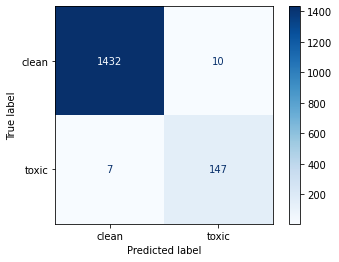

In [32]:
cm = multilabel_confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm[0], display_labels=['clean', 'toxic'])
disp.plot(cmap=plt.cm.Blues, values_format='d')

In [33]:
# predict toxicity
sentence = 'I love you'
make_prediction(sentence)

toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
clean              1
dtype: int64

In [34]:
from model.toxicity_predictor_transformer import ToxicityPredictorTransformer

# test the class
toxicityPredictor = ToxicityPredictorTransformer()
toxicityPredictor.is_sentence_clean('I love you')

True